# Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date

from pprint import pprint
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import pickle
import time

# Scraping From Main Steam Search Page
Able to Scrape:
   1. Game Title (*DataFrame Index*)
   2. Systems that the game runs on
   3. Release date of game in days
   4. Discount by numerical percent
   5. Price of Game
   6. Number of Reviews (**Dependent Variable**)

## Helper Functions
Function for parsing date elements in dataset

In [2]:
def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

Function for creating list of links to parse

In [3]:
links=['https://store.steampowered.com/search/']
for i in range(1,1954):
    links.append('https://store.steampowered.com/search/?page='+str(i))

## The Scrape

In [4]:
# cols = ['title', 'link', 'system', 'systems', 'reviews', 'release_date', 'discount', 'price']
# df=pd.DataFrame(columns=cols, index=[])

# age=date.today()
# for link in links:
#     response=requests.get(link)
#     soup = BeautifulSoup(response.text, 'html5lib')
#     try: 
#         main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
#     except:
#         time.sleep(20)
#         main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
#     print(link)
#     for game in main_search_table.find_all('a'):
#         row={}
#         row['title']=game.find('span', class_="title").text #title
#         row['link']=game['href'] #link
#         systems=[system["class"][1] for system in game.find('p').find_all('span')] #system
#         row['system']=len(systems)
#         row['systems']=systems
#         try:
#             row['release_date']=(age-(to_date(game.find('div', class_="col search_released responsive_secondrow").text).date())).days #release date  
#         except:
#             row['release_date']=0
#         for price in game.find_all('div', class_="col search_price_discount_combined responsive_secondrow"): #price and discount
#             for discount in price.find_all('div', class_="col search_discount responsive_secondrow"):
#                 if discount.find('span'):
#                     row['discount']=abs(int(discount.find('span').text.strip('%')))
#                     try:
#                         row['price']=float(price.find('span', style="color: #888888;").text.strip("$"))
#                     except:
#                         price = re.sub('[^0-9,.]','', game.find('div', class_="col search_price responsive_secondrow").text).replace("\n","").strip("\t")
#                         row['price']=price
#                 else:
#                     row['discount']=0
#                     if not game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t"):
#                         row['price']=0
#                     elif game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()[0]!='$': #'free to play' or game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()=='free':
#                         row['price']=0
#                     else:
#                         row['price']=float(game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").strip("$"))  
#         for y in game.find_all('div',class_="col search_reviewscore responsive_secondrow"):
#             x=[review['data-tooltip-html'] for review in y.find_all('span')]
#             if not x:
#                 row['reviews']=int(0)
#             else:
#                 z=x[0].split('<br>')
#                 d=z[1].split(" ")
#                 row['reviews']=int(d[3].replace(',', '')) #reviews
#         df=df.append(row, ignore_index=True)
#         with open('steam_search.pkl', 'wb') as picklefile:
#             pickle.dump(df, picklefile)
# #     time.sleep(3)
    
# df.set_index('title', inplace=True)
# df.rename(columns=lambda x: x.strip())
# pd.options.display.max_rows = 4000

Make copy of df from pickle and read into csv

In [5]:
# with open("steam_search.pkl", 'rb') as picklefile: 
#       df2 = pickle.load(picklefile)
# df2.to_csv('steam3.csv')
# df2

Read in csv from previous scrape

In [7]:
# df=pd.read_csv('steam3.csv')

### Remove Duplicates (if any)

In [8]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Modifying DataFrame Element Types to Support Regression

In [9]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)
no_dup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10475 entries, 0 to 10474
Data columns (total 9 columns):
Unnamed: 0      10475 non-null int64
title           10475 non-null object
link            10475 non-null object
system          10475 non-null int64
systems         10475 non-null object
reviews         10475 non-null int64
release_date    10475 non-null int64
discount        10475 non-null int64
price           10475 non-null float64
dtypes: float64(1), int64(5), object(3)
memory usage: 818.4+ KB


## Initial Analysis (IA): DataFrame Resulting From Main Page Scrape 
### 1. Split into Train/Test

### 2. Initial Look at Relationships with Pairplots and Correlations

In [ ]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [ ]:
no_dup_df.corr()

### 3. Run Patsy Regression

In [ ]:
#Create feature matrix and target vector
y, X = patsy.dmatrices('reviews ~ system + price + release_date + discount', data=no_dup_df)
# Create model
model = sm.OLS(y, X)

# Fit model
fit = model.fit()

# Print summary statistics of model's performance
fit.summary()

### Additional Step: Run LassoCV on Initial Dataframe

## Feature Engineering and General DataFrame Mods

### 1. Modify DF to Account for Skew by Logging Reviews; Repeat IA

In [10]:
no_dup_df['log_reviews'] = np.log(no_dup_df.reviews + 1)

(array([3209., 1259., 2171., 1656., 1119.,  656.,  316.,   67.,   16.,
           6.]),
 array([ 0.        ,  1.47819821,  2.95639642,  4.43459463,  5.91279284,
         7.39099105,  8.86918926, 10.34738747, 11.82558568, 13.3037839 ,
        14.78198211]),
 <a list of 10 Patch objects>)

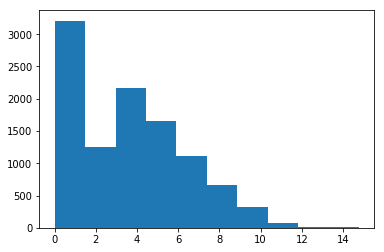

In [11]:
plt.hist(no_dup_df['log_reviews'])

### 2. Drop Movies

In [ ]:
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:  
        print(element)

### 3. Seperate Windows/Mac/Linux into Individual Bool 0/1 Columns; Repeat IA

In [12]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [13]:
no_dup_df['windows']=pd.Series(windows)
no_dup_df['mac']=pd.Series(mac)
no_dup_df['linux']=pd.Series(linux)

In [14]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
no_dup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10475 entries, 0 to 10474
Data columns (total 13 columns):
Unnamed: 0      10475 non-null int64
title           10475 non-null object
link            10475 non-null object
system          10475 non-null int64
systems         10475 non-null object
reviews         10475 non-null int64
release_date    10475 non-null int64
discount        10475 non-null int64
price           10475 non-null float64
log_reviews     10475 non-null float64
windows         10475 non-null int64
mac             10475 non-null int64
linux           10475 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


# Scraping from Individual Game Pages
Available data:
    1. Genre
    2. Single/Multiplayer
    3. Number of Languages
    4. Developer
    5. Publisher
    6. User-defined tages
    7. Release date (repeat)
    8. Recent Updates
    9. System Requirements

## The Scrape

In [ ]:
cols2 = ['title', 'developer', 'user_tags', 'languages', 'genres', 'specs']
df_gamepg=pd.DataFrame(columns=cols2, index=[])
link_games=list(no_dup_df.link)

for link in link_games:
    try:
        response=requests.get(link)
        soup = BeautifulSoup(response.text, 'html5lib')
        row1={}
        row1['title']=soup.find('div', class_='apphub_AppName').text
        for developers in soup.find_all('div', class_="summary column", id="developers_list"):
            developer=[one_developer.text for one_developer in developers.find_all('a')]
        row1['developer']=developer
        user_tags=[tag.text.replace("\n","").strip("\t") for tag in soup.find_all('a', class_="app_tag")]
        row1['user_tags']=user_tags
        all_lang=[]
        for languages in soup.find_all('table', class_="game_language_options"):
            for element in languages.find_all('tr', style=True, class_=True):
                language=(element.find('td', class_="ellipsis").text.replace("\n","").strip("\t"))
                options=[language if bool(options.text.replace("\n","").strip("\t")) else 0 for options in element.find_all('td', class_="checkcol")]
                all_lang.append(tuple(options))
        row1['languages']=all_lang
        x=soup.find_all('div', class_="details_block")[0].text.replace("\n","").split("\t")
        feature_list = list(filter(None, x))
        y=feature_list[1].split(":")
        genres=y[1]
        row1['genres']=genres
        specs=[]
        for element in soup.find_all('div', class_="game_area_details_specs"):
            l=[]
            for e2 in element.find_all('a'):
                l.append(e2.text.replace("\n","").strip("\t"))
            specs.extend(l)
        full_specs=list(filter(None, specs))
        row1['specs']=full_specs 
        df_gamepg=df_gamepg.append(row1, ignore_index=True)
    except:
        print(link)
df_gamepg.set_index('title', inplace=True)
df_gamepg.rename(columns=lambda x: x.strip())
pd.options.display.max_rows = 4000
df_gamepg

https://store.steampowered.com/app/230410/Warframe/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/230410/Warframe/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/629910/Clicker_Heroes_2/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/359550/Tom_Clancys_Rainbow_Six_Siege/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/359550/Tom_Clancys_Rainbow_Six_Siege/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/271590/Grand_Theft_Auto_V/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/271590/Grand_Theft_Auto_V/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/574090/MOTHERGUNSHIP/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/252950/Rocket_League/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/728540/Islands_of_Nyne_Battle_Royale/?snr=1_7_7_230_150_1
https://store.steampowered.com/app/570/Dota_2/?snr=1_7_7_230_150_1
https://store.steampo

https://store.steampowered.com/app/548430/Deep_Rock_Galactic/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/22380/Fallout_New_Vegas/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/22380/Fallout_New_Vegas/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/845640/Sonic_Mania__Encore_DLC/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/431960/Wallpaper_Engine/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/292030/The_Witcher_3_Wild_Hunt/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/292030/The_Witcher_3_Wild_Hunt/?snr=1_7_7_230_150_3
https://store.steampowered.com/app/594650/Hunt_Showdown/?snr=1_7_7_230_150_3


In [ ]:
df

In [ ]:
df_gamepg

In [ ]:
no_dup_df

In [ ]:
no_dup_gamepg_df